In [1]:
import _heatmap
from _heatmap import *
import matplotlib
import matplotlib.pyplot as plt
import warnings
import _convert_index2labels

warnings.filterwarnings('ignore')
font = {'size'   : 12}
matplotlib.rc('font', **font)
frequency_threshold = 0.005
zone_threshold = 0.5
#chain_id_pair = [1,0] # A: receptor, B: ligand ## the first item represents ligand, second is receptor
gap = False # there are gaps in G alpha
stride = 10
spec_id = 1
fix_or_not = True
import _TM_table
import numpy as np
import main
import os

In [2]:
TM_dic = _TM_table.convert_Residue2TMs()
def converting(chain_list, chain_id_pair, initial_indexes, boundary_indexes, indexes_contact, gap,TM_dic,spec_id):
    convert_step = _convert_index2labels.Convert(chain_list, chain_id_pair, initial_indexes, boundary_indexes, indexes_contact, gap,TM_dic,spec_id)
    labels = convert_step.resid_Mdtraj2PDB()
    return labels

In [3]:
def union_calc(simulation_lists,stride, chain_id_pair, gap, zone_threshold, frequency_threshold,TM_dic,spec_id,fix_or_not, fixed_indexes_contact,ligand_top):
    full_indexes_contact = {}
    fix_or_not = False
    for i in range(len(simulation_lists)):
        system_name = simulation_lists[i]
        os.chdir(system_name+'/output/')
        top_pdb = system_name+'.pdb'
        traj_dcd = 'interval1200_'+system_name+'.dcd'
        frequency_matrix, indexes_contact,initial_indexes,boundary_indexes,chain_list = main.workflow(top_pdb, traj_dcd, stride, chain_id_pair, gap, zone_threshold, frequency_threshold,TM_dic,spec_id,fix_or_not, fixed_indexes_contact,ligand_top)
        #print (chain_list,boundary_indexes,initial_indexes, indexes_contact  )
        full_indexes_contact[system_name] = indexes_contact
        os.chdir('../..')
    # make union set #
    tmp_fixed_indexes_contact={}
    for pair_id in indexes_contact.keys():
        full_indexes_list = []
        for key in full_indexes_contact.keys():
            for r in full_indexes_contact[key][pair_id]:
                full_indexes_list.append(r)
        full_indexes_list = sorted(list(set(full_indexes_list)))
        tmp_fixed_indexes_contact[pair_id] = full_indexes_list

    #-------- USE UNION SET for recalculating ------#
    fix_or_not = True
    full_frequency_matrix = {}
    
    if fixed_indexes_contact!={}:
        fixed_indexes_contact = fixed_indexes_contact
    else:
        fixed_indexes_contact = tmp_fixed_indexes_contact
    for i in range(len(simulation_lists)):
        system_name = simulation_lists[i]
        os.chdir(system_name+'/output/')
        top_pdb = system_name+'.pdb'
        traj_dcd = 'interval1200_'+system_name+'.dcd'
        frequency_matrix, indexes_contact, initial_indexes,boundary_indexes,chain_list = main.workflow(top_pdb, traj_dcd, stride, chain_id_pair, gap, zone_threshold, frequency_threshold,TM_dic,spec_id,fix_or_not, fixed_indexes_contact,ligand_top)
        full_indexes_contact[system_name] = indexes_contact
        full_frequency_matrix[system_name] = frequency_matrix
        os.chdir('../..')
    #------- Take average of the metrics ----------#
    key = list(full_frequency_matrix.keys())[0]
    matrix = full_frequency_matrix[key]
    full_matrix = np.zeros((matrix.shape[0], matrix.shape[1]))

    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            for key in full_frequency_matrix.keys():
                full_matrix[i][j] += full_frequency_matrix[key][i][j]
            full_matrix[i][j] = full_matrix[i][j]/float(len(full_frequency_matrix.keys()))

    return full_matrix, indexes_contact,initial_indexes,boundary_indexes,chain_list


  0%|          | 0/209 [00:00<?, ?it/s]

{0: [0, 1, 4, 8, 11, 43, 46, 47, 48, 49, 52, 53, 54, 55, 56, 58, 59, 62, 63, 66, 110, 115, 116, 118, 119, 123, 126, 157, 158, 161, 164, 165, 168, 172, 174, 176, 179], 1: [209]}


100%|██████████| 37/37 [00:00<00:00, 553.14it/s]


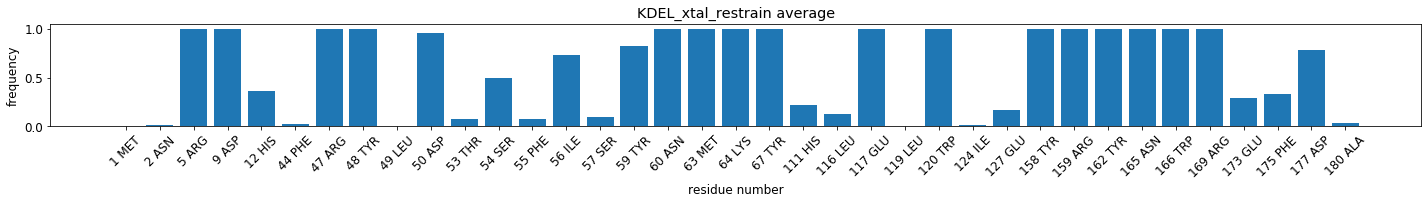

{0: [0, 1, 4, 8, 11, 43, 46, 47, 48, 49, 52, 53, 54, 55, 56, 58, 59, 62, 63, 66, 110, 115, 116, 118, 119, 123, 126, 157, 158, 161, 164, 165, 168, 172, 174, 176, 179], 1: [209]} {0: [(0, 209)], 1: [(209, 210)]} {0: 1, 1: 1}


<Figure size 432x288 with 0 Axes>

In [4]:
ligand_top = False
chain_id_pair = [0,1] # A: receptor, B: ligand ## the first item represents ligand, second is receptor

fixed_indexes_contact = {}
fixed_indexes_contact[chain_id_pair[0]] = sorted([i-1 for i in [1,2, 5, 9, 12, 158, 159, 162, 165, 166, 169, 44, 173, 47, 48, 49, 50, 175, 177, 53, 54, 55, 56, 57, 180, 59, 60, 63, 64, 67,  111, 116, 117, 119, 120, 124, 127]])
fixed_indexes_contact[chain_id_pair[1]] = [209]
print (fixed_indexes_contact)

simulation_lists=['KDEL_xtal_restrain','KDEL_xtal_restrain_rep1','KDEL_xtal_restrain_rep2']
full_matrix_x, indexes_contact_x,initial_indexes,boundary_indexes,chain_list = union_calc(simulation_lists,stride, chain_id_pair, gap, zone_threshold, frequency_threshold,TM_dic,spec_id,fix_or_not, fixed_indexes_contact,ligand_top)
labels = converting(chain_list, chain_id_pair, initial_indexes, boundary_indexes, indexes_contact_x, gap,TM_dic,spec_id)

plt.figure(figsize=(20,3))
plt.title(simulation_lists[0]+' average')
vals = []
tem = {}
vals = full_matrix_x[:,0]
plt.bar(range(len(vals)), vals)
plt.xticks(range(len(labels[chain_id_pair[0]])),[x for x in labels[chain_id_pair[0]]],rotation=45)
plt.xlabel('residue number')
plt.ylabel('frequency')
plt.tight_layout()
plt.savefig('contact_residues_'+simulation_lists[0]+'.png')
plt.show()
plt.clf()
print (indexes_contact_x, boundary_indexes, initial_indexes)

100%|██████████| 37/37 [00:00<00:00, 532.17it/s]


{0: [0, 1, 4, 8, 11, 43, 46, 47, 48, 49, 52, 53, 54, 55, 56, 58, 59, 62, 63, 66, 110, 115, 116, 118, 119, 123, 126, 157, 158, 161, 164, 165, 168, 172, 174, 176, 179], 1: [213]}


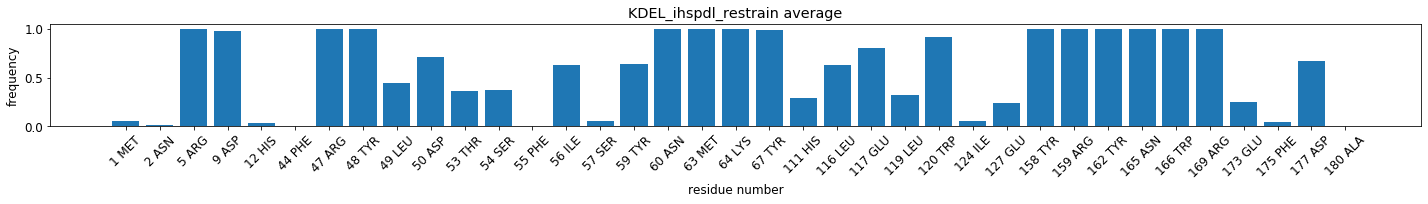

<Figure size 432x288 with 0 Axes>

In [5]:
ligand_top = False
chain_id_pair = [0,1] # A: receptor, B: ligand ## the first item represents ligand, second is receptor
fixed_indexes_contact = {}
fixed_indexes_contact[chain_id_pair[0]] = sorted([i-1 for i in [1,2,5, 9, 12, 158, 159, 162, 165, 166, 169, 44, 173, 47, 48, 49, 50, 175, 177, 53, 54, 55, 56, 57, 180, 59, 60, 63, 64, 67, 111, 116, 117, 119, 120, 124, 127]])
fixed_indexes_contact[chain_id_pair[1]] = [213]
simulation_lists=['KDEL_ihspdl_restrain','KDEL_ihspdl_restrain_rep1']
full_matrix_ih, indexes_contact_ih,initial_indexes,boundary_indexes,chain_list = union_calc(simulation_lists,stride, chain_id_pair, gap, zone_threshold, frequency_threshold,TM_dic,spec_id,fix_or_not, fixed_indexes_contact,ligand_top)
print (indexes_contact_ih)
#labels = converting(chain_list, chain_id_pair, initial_indexes, boundary_indexes, indexes_contact_ih, gap,TM_dic,spec_id)
#print (fixed_indexes_contact, initial_indexes, boundary_indexes)

plt.figure(figsize=(20,3))
plt.title(simulation_lists[0]+' average')
vals = []
tem = {}
vals = full_matrix_ih[:,0]
plt.bar(range(len(vals)), vals)
plt.xticks(range(len(labels[chain_id_pair[0]])),[x for x in labels[chain_id_pair[0]]],rotation=45)
plt.xlabel('residue number')
plt.ylabel('frequency')
plt.tight_layout()
plt.savefig('contact_residues_'+simulation_lists[0]+'.png')
plt.show()
plt.clf()


In [6]:
#print (chain_list[0].residue(179))

100%|██████████| 37/37 [00:00<00:00, 609.53it/s]


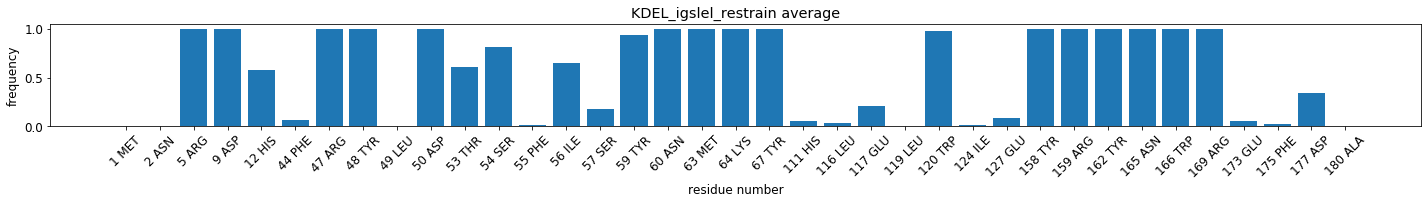

{1: [1, 2, 5, 9, 12, 44, 47, 48, 49, 50, 53, 54, 55, 56, 57, 59, 60, 63, 64, 67, 111, 116, 117, 119, 120, 124, 127, 158, 159, 162, 165, 166, 169, 173, 175, 177, 180], 0: [0]} {1: 1, 0: 0} {1: [(1, 209)], 0: [(0, 1)]}


<Figure size 432x288 with 0 Axes>

In [7]:
ligand_top = True
chain_id_pair = [1,0] # A: receptor, B: ligand ## the first item represents ligand, second is receptor
fixed_indexes_contact = {}
fixed_indexes_contact[chain_id_pair[0]] = sorted([i for i in [1,2, 5, 9, 12, 158, 159, 162, 165, 166, 169, 44, 173, 47, 48, 49, 50, 175, 177, 53, 54, 55, 56, 57, 180, 59, 60, 63, 64, 67, 111, 116, 117, 119, 120, 124, 127]])
fixed_indexes_contact[chain_id_pair[1]] = [0]
#print (fixed_indexes_contact, initial_indexes, boundary_indexes)

simulation_lists=['KDEL_igslel_restrain','KDEL_igslel_restrain_rep1','KDEL_igslel_restrain_rep2']
full_matrix_ig, indexes_contact_ig,initial_indexes,boundary_indexes,chain_list = union_calc(simulation_lists,stride, chain_id_pair, gap, zone_threshold, frequency_threshold,TM_dic,spec_id,fix_or_not, fixed_indexes_contact,ligand_top)
labels = converting(chain_list, chain_id_pair, initial_indexes, boundary_indexes, indexes_contact_ig, gap,TM_dic,spec_id)

plt.figure(figsize=(20,3))
plt.title(simulation_lists[0]+' average')
vals = []
tem = {}
vals = full_matrix_ig[:,0]
plt.bar(range(len(vals)), vals)
plt.xticks(range(len(labels[chain_id_pair[0]])),[x for x in labels[chain_id_pair[0]]],rotation=45)
plt.xlabel('residue number')
plt.ylabel('frequency')
plt.tight_layout()
plt.savefig('contact_residues_'+simulation_lists[0]+'.png')
plt.show()
plt.clf()
print (indexes_contact_ig,initial_indexes, boundary_indexes)

In [8]:
#fixed_indexes_contact = {}
#rearrange_ig = set([i+1 for i in indexes_contact_ig[chain_id_pair[0]]])
#receptor_indexes = list(set(indexes_contact_x[chain_id_pair[0]]).union(indexes_contact_ih[chain_id_pair[0]]).union(rearrange_ig))
#print (receptor_indexes)
print (len(labels[1]))

37


In [9]:
#target_dic = total_connect['KDEL_xtal_restrain']
#ig = total_connect['KDEL_igslel_restrain']
#ih = total_connect['KDEL_ihspdl_restrain']
diff_ig = {}
diff_ih = {}
for_table_list = [] # order is: key, KDEL_xtal_restrain_value,ig_value,ih_value, ig_diff, ih_diff
for_table_list.append(['Residues','AEKDEL cont freq','IGSLEL cont freq', 'IHSPDL cont freq','AEKDEL-IGSLEL','AEKDEL-IHSPDL'])
for i in range(len(labels[1])):
    diff_ig[labels[1][i]] = round(full_matrix_x[i,0]- full_matrix_ig[i,0],2)
    diff_ih[labels[1][i]] = round(full_matrix_x[i,0] - full_matrix_ih[i,0],2)
    for_table_list.append([labels[1][i],round(full_matrix_x[i,0],2),round(full_matrix_ig[i,0],2), round(full_matrix_ih[i,0],2), diff_ig[labels[1][i]], diff_ih[labels[1][i]]])
print (diff_ig)

{'1 MET': 0.0, '2 ASN': 0.02, '5 ARG': 0.0, '9 ASP': -0.0, '12 HIS': -0.22, '44 PHE': -0.04, '47 ARG': 0.0, '48 TYR': 0.0, '49 LEU': -0.01, '50 ASP': -0.05, '53 THR': -0.52, '54 SER': -0.32, '55 PHE': 0.07, '56 ILE': 0.07, '57 SER': -0.08, '59 TYR': -0.1, '60 ASN': 0.0, '63 MET': 0.0, '64 LYS': 0.0, '67 TYR': -0.0, '111 HIS': 0.17, '116 LEU': 0.1, '117 GLU': 0.79, '119 LEU': 0.0, '120 TRP': 0.03, '124 ILE': 0.0, '127 GLU': 0.08, '158 TYR': 0.0, '159 ARG': 0.0, '162 TYR': 0.0, '165 ASN': -0.0, '166 TRP': 0.0, '169 ARG': 0.0, '173 GLU': 0.23, '175 PHE': 0.3, '177 ASP': 0.45, '180 ALA': 0.03}


In [10]:
from IPython.display import HTML, display
display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in for_table_list)
       )
))


Residues,AEKDEL cont freq,IGSLEL cont freq,IHSPDL cont freq,AEKDEL-IGSLEL,AEKDEL-IHSPDL
1 MET,0.0,0.0,0.06,0.0,-0.05
2 ASN,0.02,0.0,0.02,0.02,0.0
5 ARG,1.0,1.0,1.0,0.0,0.0
9 ASP,0.99,1.0,0.98,-0.0,0.02
12 HIS,0.36,0.58,0.04,-0.22,0.32
44 PHE,0.03,0.07,0.0,-0.04,0.03
47 ARG,1.0,1.0,1.0,0.0,0.0
48 TYR,1.0,1.0,1.0,0.0,0.0
49 LEU,0.0,0.01,0.44,-0.01,-0.44
50 ASP,0.95,1.0,0.72,-0.05,0.24
